In [1]:
# Import packages
import numpy as np
from numpy import dtype
import netCDF4 as nc
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn
from scipy import stats,signal
from scipy.spatial.distance import cdist
import datetime as dt
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.mpl.ticker as cticker
import cftime
import dask
from dask.distributed import Client, progress
import dask.array as da
import collections
import scipy as scipy
from scipy.signal import detrend
from scipy import stats,signal
import cfgrib
import os
import glob
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from eofs.standard import Eof
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [2]:
def rearrange_by_frequency(array):
    # Count the occurrences of each unique value
    unique, counts = np.unique(array, return_counts=True)
    freq_map = dict(zip(unique, counts))
    
    # Sort unique values by descending frequency
    sorted_values = sorted(freq_map.keys(), key=lambda x: freq_map[x], reverse=True)
    
    # Create a mapping where the most frequent gets 0, second most gets 1, etc.
    mapping = {old_val: new_val for new_val, old_val in enumerate(sorted_values)}
    
    # Apply the mapping to the array
    rearranged_array = np.vectorize(mapping.get)(array)
    return rearranged_array, mapping

In [14]:
#define the latlon domain and the time period
lat1=24;lat2=55
lon1=230;lon2=300
lev0 = 500
iyr1=1960; iyr2=2022
nyr=iyr2-iyr1+1
dt01='-04-01';dt02='-07-31'
ndy=(date(1979,7,31)-date(1979,4,1)).days +1

In [4]:
#number of weather regimes
nclusters=5

In [5]:
# Input file data
dir = f'/glade/u/home/mgraber/ERA5/*.nc'

In [7]:
df = xr.open_mfdataset(dir)

In [8]:
df_all = df
# Now select only April 1 to July 31 for every year

# Define year range
start_year = 1960
end_year = 2022

df_filtered = df_all.sel(time=df_all.time.where(
    (
        ((df_all.time.dt.month > 3) & (df_all.time.dt.month < 8)) |
        ((df_all.time.dt.month == 4) & (df_all.time.dt.day >= 1)) |
        ((df_all.time.dt.month == 7) & (df_all.time.dt.day <= 31))
    )
    & 
    ((df_all.time.dt.year >= start_year) & (df_all.time.dt.year <= end_year))
).dropna('time'))

/glade/u/home/mgraber/.conda/envs/myenv/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [9]:
#read daily z500 data
#note that the latitude dimension is reversed
for iyr in range(iyr1,iyr2+1):
   tm1=str(iyr)+dt01 
   tm2=str(iyr)+dt02 
   hgt0=df.heights.sel(time=slice(tm1,tm2), longitude=slice(lon1,lon2), latitude=slice(lat2,lat1))
   if iyr==iyr1:	#initialize hgt and extract latlon info
      lats=hgt0['latitude'].values;
      lons=hgt0['longitude'].values;
      nn,nlat,nlon=hgt0.shape
      heights=np.zeros((nyr,ndy,nlat,nlon))

   hgt01=xr.concat([hgt0], dim='time')
   heights[iyr-iyr1,:,:,:]=hgt01.rolling(time=5,center=True,min_periods=5).mean()
print('Finish reading H500')
hgt2=heights[0]

Finish reading H500


In [10]:
data = df_filtered.heights
# Reshape data to group every 61 days (each year) together
reshaped = data.coarsen(time=122, boundary="trim").mean()

# Compute the mean across all grid points and pressure levels
annual_means = reshaped.mean(dim=["latitude", "longitude"]).compute()

# Convert to NumPy array if needed
annual_means_np = annual_means.values

In [11]:
#remove the seasonal cycle (the 63-year running mean on each calendar day) for April 1st-July 31st
heights=heights[:,2:124,:,:]-np.mean(heights[:,2:124,:,:],axis=0)

In [13]:
from scipy.stats import linregress
# heights: shape [nyears, ndays, nlat, nlon]
ny, nd, nlat, nlon = heights.shape

# Prepare regression variable: NH seasonal mean trend
X = (annual_means_np - np.mean(annual_means_np))  # seasonal means shape is (ny,)
#X = X[:, np.newaxis]  # shape: [ny, 1]

# Loop over calendar days, latitudes, and longitudes to regress out hemispheric seasonal trend
for iday in range(nd):
    for ilat in range(nlat):
        for ilon in range(nlon):
            y = heights[:, iday, ilat, ilon]
            slope, intercept, _, _, _ = linregress(X, y)
            trend_component = slope * X + intercept
            heights[:, iday, ilat, ilon] = y - trend_component

In [15]:
#calculate a cosine weighting function
lon2d,lat2d=np.meshgrid(lons,lats)
wgt=np.cos(lat2d*np.pi/180.0)
wgts=np.repeat(wgt[np.newaxis,:],nyr*ndy,axis=0)

In [16]:
#reshape the data to [ny*nday, nlon*nlat]
hgt0=np.reshape(heights,(nyr*ndy,nlat,nlon))	#un-weighted H500
wgts=np.reshape(wgts,(nyr*ndy,nlat*nlon))
heights=np.reshape(heights,(nyr*ndy,nlat*nlon))
heights=heights*wgts

In [17]:
# Apply an EOF filter
solver = Eof(heights)

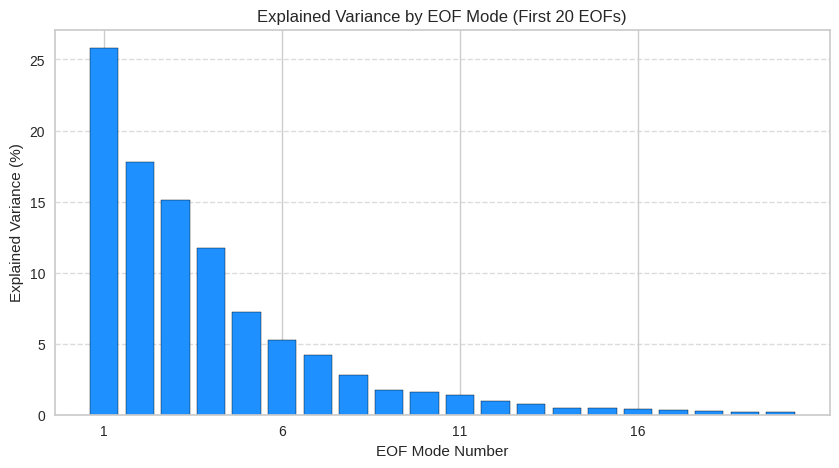

In [18]:
# Assuming `solver` is already computed from your EOF analysis
variance_fraction = solver.varianceFraction()  # Get all variance fractions

# Select the first 20 EOFs
variance_fraction_percent = variance_fraction[:20] * 100  # Convert to percentage

# Plot the explained variance
plt.figure(figsize=(10, 5))
plt.bar(range(1, 21), variance_fraction_percent, color='dodgerblue', edgecolor='black')

# Labels and title
plt.xlabel("EOF Mode Number")
plt.ylabel("Explained Variance (%)")
plt.title("Explained Variance by EOF Mode (First 20 EOFs)")
plt.xticks(range(1, 21, 5))  # Show every 5th EOF number for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [19]:
# Step 2: Retain the first 8 EOFs
n_eofs = 8
pc_scores = solver.pcs(npcs=n_eofs, pcscaling=1)  # Principal Component scores
eof_modes = solver.eofs(neofs=n_eofs)  # Spatial EOFs
eigenvalues = solver.eigenvalues()[:n_eofs]  # First 8 eigenvalues

# Step 3: Scale EOFs by the square root of eigenvalues
eof_modes_scaled = eof_modes * np.sqrt(eigenvalues[:, np.newaxis])

# Step 4: Reconstruct the filtered dataset
heights_eof_filtered = np.tensordot(pc_scores, eof_modes_scaled, axes=(1, 0))

# Step 5: Check variance again
print("% of Variance account for:", np.var(heights_eof_filtered)/np.var(heights) * 100)

% of Variance account for: 89.92857488146687


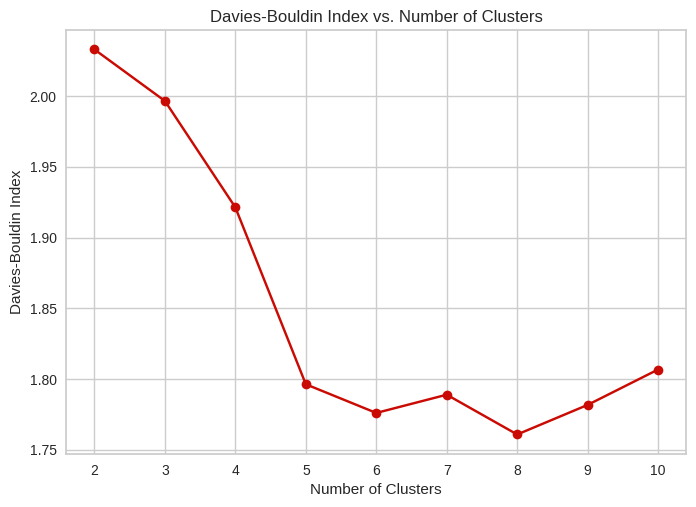

In [20]:
dbi_scores = []
K = range(2, 11)  
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(heights_eof_filtered)
    labels = kmeans.labels_
    dbi_scores.append(davies_bouldin_score(heights_eof_filtered, labels))

# Optional: Plot DBI scores
plt.plot(K, dbi_scores, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.show()

In [ ]:
#apply the k-mean cluster analysis
km_standard = KMeans(n_clusters=nclusters,random_state=0, n_init=20).fit(heights_eof_filtered)
labels = km_standard.labels_ 		#of the dimension (nyr*ndy)
WR0 = km_standard.cluster_centers_	#cluster centers
WR0 = np.reshape(WR0,(nclusters,nlat,nlon))

In [ ]:
# Calculate unique counts and frequencies
unique, counts = np.unique(labels, return_counts=True)
freq = np.round(100.0 * counts / len(labels), 1)

In [ ]:
#calculate the cluster mean using un-weighted data
WRs=np.zeros((nclusters,nlat,nlon)) 
for i in unique:
    D=np.where(labels==i)
    WRs[i]=np.nanmean(hgt0[D],axis=0)

In [ ]:
#order WRs with descending freq. by multiplying -1.0
ii=np.argsort(-1.0*freq)
freq=freq[ii]
WRs=WRs[ii]

In [ ]:
#relabel
ll=np.copy(labels)
for i in range(nclusters):
   labels[ll==ii[i]]=i

In [ ]:
np.save('19602022_WRsdownload_AMJJ_ERA5_structures.npy', WRs)

In [ ]:
# plot each regime
mode_name=['(a)','(b)','(c)','(d)', '(e)']
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(12,8),
    subplot_kw={'projection': ccrs.PlateCarree()})

axes=axes.T.flat
for kk in range(nclusters):
    axx=axes[kk]
    levels=np.arange(-80,80.1,10)
    im0 = axx.contourf(lon2d,lat2d,WRs[kk],levels,cmap = plt.get_cmap('RdBu_r'),extend='both')
    im1 = axx.contour(lon2d,lat2d,WRs[kk],levels,colors='k')
 
    axx.coastlines()
    axx.set_title(mode_name[kk]+' '+str(freq[kk])+'%',fontsize=15,loc='left')
    axx.add_feature(cf.BORDERS)
    axx.add_feature(cf.STATES)
    kk=kk+1
plt.suptitle('ERA-5 AMJJ 1960-2022',fontsize=15,y=0.98)
fig.tight_layout()
plt.subplots_adjust(top=0.85,bottom=0.15,left=0.10,right=0.95,hspace=0.3,
wspace=0.20)
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03]) # left, bottom height ,length, width
fig.colorbar(im0,orientation='horizontal',cax=cbar_ax)
fmt="png"
#plt.savefig('WR-H500-5-AMJJ-20002022_ERA5_structures.'+fmt,format=fmt,bbox_inches='tight')
plt.show(block=False)
print('Normal End!') 